In [162]:
import pandas as pd
import seaborn as sb
import numpy as np
import math
import matplotlib.pyplot as plt

In [163]:
df_path = '../../data/whisper-small-runs.csv'
df = pd.read_csv(df_path)
df.head()

/var/folders/bt/_dsrh6ld2yncbnn9vk_d2lcc0000gp/T/ipykernel_3354/3434655983.py:2: DtypeWarning: Columns (5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_path)


,index,step,tag,value,experiment_name,date,checkpoint,csv_name,preds_name,lid_loss_alpha,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch
0,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1.0,1341,eval/tira_eval-en+sw_cer,0.736247,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2.0,2682,eval/tira_eval-en+sw_cer,0.692670,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,2
3,3.0,4023,eval/tira_eval-en+sw_cer,0.765299,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,3
4,4.0,5364,eval/tira_eval-en+sw_cer,0.819973,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,4


In [164]:
df['experiment_name'].unique()

array(['whisper-small-tira', 'whisper-small-tira-all-clean',
       'whisper-small-tira-all-clean-ewc-lambda-1',
       'whisper-small-tira-all-clean-lid-alpha-0.2',
       'whisper-small-tira-all-clean-lid-alpha-0.2-ewc-lambda-1',
       'whisper-small-tira-all-long-lid-alpha-0.2-ewc-lambda-1',
       'whisper-small-tira-eng', 'whisper-small-tira-eng-cs',
       'whisper-small-tira-eng-cs-50-50',
       'whisper-small-tira-eng-cs-50-50-ewc-lambda-1',
       'whisper-small-tira-eng-cs-50-50-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-clean',
       'whisper-small-tira-eng-cs-clean-ewc-lambda-1',
       'whisper-small-tira-eng-cs-clean-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-clean-lid-alpha-0.2-ewc-lambda-1',
       'whisper-small-tira-eng-cs-ewc-lambda-1',
       'whisper-small-tira-eng-cs-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-lid-alpha-0.2-ewc-lambda-1',
       'whisper-small-tira-eng-cs-long',
       'whisper-small-tira-eng-cs-long-ewc-lambda-1',
       'w

In [183]:
# get more detailed colnames
get_metric = lambda s: 'cer' if s.endswith('cer') else 'wer' if s.endswith('wer') else ''
df['metric']=df['tag'].apply(get_metric)
# df.loc[df['tag'].str.contains('test'),'metric']=''
df['metric'].value_counts()

metric
       90168
cer     3202
wer     3202
Name: count, dtype: int64

In [166]:
df

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,preds_name,lid_loss_alpha,...,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch,metric
0,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,NaN,...,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,0,cer
1,1.0,1341,eval/tira_eval-en+sw_cer,0.736247,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,NaN,...,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,1,cer
2,2.0,2682,eval/tira_eval-en+sw_cer,0.692670,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,NaN,...,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,2,cer
3,3.0,4023,eval/tira_eval-en+sw_cer,0.765299,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,NaN,...,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,3,cer
4,4.0,5364,eval/tira_eval-en+sw_cer,0.819973,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,NaN,...,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,4,cer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96567,NaN,10728,test_eng_cer_processed,0.300424,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1,NaN,NaN,NaN,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1/...,0.2,...,-1,False,NaN,NaN,1.0,NaN,NaN,NaN,8,
96568,NaN,10728,test_misc_cer_processed,0.430593,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1,NaN,NaN,NaN,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1/...,0.2,...,-1,False,NaN,NaN,1.0,NaN,NaN,NaN,8,
96569,NaN,10728,test_runtime,27.387800,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1,NaN,NaN,NaN,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1/...,0.2,...,-1,False,NaN,NaN,1.0,NaN,NaN,NaN,8,
96570,NaN,10728,test_samples_per_second,6.390000,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1,NaN,NaN,NaN,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1/...,0.2,...,-1,False,NaN,NaN,1.0,NaN,NaN,NaN,8,


In [167]:
df['epoch']=0
epoch_mask = df['tag'].str.contains('epoch')
for i, row in df[epoch_mask].iterrows():
    step_mask = df['step']==row['step']
    exp_mask = df['experiment_name']==row['experiment_name']
    df.loc[step_mask & exp_mask, 'epoch'] = int(row['value'])
df

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,preds_name,lid_loss_alpha,...,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch,metric
0,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,NaN,...,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,0,cer
1,1.0,1341,eval/tira_eval-en+sw_cer,0.736247,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,NaN,...,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,1,cer
2,2.0,2682,eval/tira_eval-en+sw_cer,0.692670,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,NaN,...,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,2,cer
3,3.0,4023,eval/tira_eval-en+sw_cer,0.765299,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,NaN,...,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,3,cer
4,4.0,5364,eval/tira_eval-en+sw_cer,0.819973,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,NaN,...,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,4,cer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96567,NaN,10728,test_eng_cer_processed,0.300424,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1,NaN,NaN,NaN,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1/...,0.2,...,-1,False,NaN,NaN,1.0,NaN,NaN,NaN,8,
96568,NaN,10728,test_misc_cer_processed,0.430593,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1,NaN,NaN,NaN,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1/...,0.2,...,-1,False,NaN,NaN,1.0,NaN,NaN,NaN,8,
96569,NaN,10728,test_runtime,27.387800,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1,NaN,NaN,NaN,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1/...,0.2,...,-1,False,NaN,NaN,1.0,NaN,NaN,NaN,8,
96570,NaN,10728,test_samples_per_second,6.390000,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1,NaN,NaN,NaN,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1/...,0.2,...,-1,False,NaN,NaN,1.0,NaN,NaN,NaN,8,


In [168]:
unique_datasets = ['fl_en', 'HH20210312', 'HH20210913', 'tira-clean-split', 'sasoc-cs', 'sasoc-zul', 'sasoc-en', 'nchlt_zul', 'nchlt_eng', 'tira_cs']

def get_dataset(s):
    for dataset in unique_datasets:
        if dataset in s:
            return dataset


df['dataset']=df['tag'].apply(get_dataset)
df['dataset'].value_counts()

dataset
sasoc-cs     2520
fl_en        2052
nchlt_zul    1572
Name: count, dtype: int64

In [169]:
# so we can compare no LID loss to using LID loss
df['lid_loss_alpha']=df['lid_loss_alpha'].fillna(0)
df['ewc_lambda']=df['ewc_lambda'].fillna(0)

In [170]:
df['ewc']=df['ewc_lambda']>0
df['lid_loss']=df['lid_loss_alpha']>0
df['regularization']='none'
df.loc[df['ewc'], 'regularization']='ewc'
df.loc[df['lid_loss'], 'regularization']='lid_loss'
df.loc[df['ewc'] & df['lid_loss'], 'regularization']='ewc+lid_loss'

In [171]:
df['train_data']='tira'
df.loc[df['experiment_name'].str.contains('tira-eng'), 'train_data']='tira-eng'
df.loc[df['experiment_name'].str.contains('tira-eng-50pct'), 'train_data']='tira-eng-50pct'
df.loc[df['experiment_name'].str.contains('tira-eng-cs'), 'train_data']='misc'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-20-80-small'), 'train_data']='tira-eng-cs-20-80-small'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-20-80-large'), 'train_data']='tira-eng-cs-20-80-large'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-50-50-large'), 'train_data']='tira-eng-cs-50-50'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-clean'), 'train_data']='tira-eng-cs-clean'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-long'), 'train_data']='tira-eng-cs-long'
df.loc[df['experiment_name'].str.contains('tira-all'), 'train_data']='tira-all'
df.loc[df['experiment_name'].str.contains('tira-all-clean'), 'train_data']='tira-all-clean'
df.loc[df['experiment_name'].str.contains('tira-all-long'), 'train_data']='tira-all-long'

df.loc[df['experiment_name'].str.contains('zulu'), 'train_data']='zulu'
df.loc[df['experiment_name'].str.contains('zulu-swahili-eng'), 'train_data']='zulu+eng'
df.loc[df['experiment_name'].str.contains('zulu-swahili-eng-50pct'), 'train_data']='zulu+eng-50pct'
df.loc[df['experiment_name'].str.contains('zulu-eng-cs'), 'train_data']='zulu-eng-cs'
df.loc[df['experiment_name'].str.contains('zulu-eng-all'), 'train_data']='zulu-eng-all'

df['train_data'].value_counts()

train_data
zulu-eng-cs          26006
zulu+eng             25802
zulu                 13556
zulu-eng-all          8942
zulu+eng-50pct        8016
tira-all-clean        7932
tira                  3210
tira-eng              1094
misc                   742
tira-eng-cs-clean      726
tira-eng-cs-long       376
tira-all-long          170
Name: count, dtype: int64

In [172]:
df.loc[
    df['experiment_name'].str.contains('tira')&df['tag'].str.contains('eval')&df['dataset'].isna(),
    'dataset'
] = 'tira-cs'
df['dataset'].value_counts()

dataset
tira-cs      10419
sasoc-cs      2520
fl_en         2052
nchlt_zul     1572
Name: count, dtype: int64

In [173]:
df.loc[
    (df['train_data']=='zulu-eng-all')&df['tag'].str.contains('eval')&df['dataset'].isna(),
    'dataset'
] = 'sasoc-cs'
df['dataset'].value_counts()

dataset
sasoc-cs     11225
tira-cs      10419
fl_en         2052
nchlt_zul     1572
Name: count, dtype: int64

In [174]:
df=df.sort_values('step')
for experiment in df['experiment_name'].unique():
    for tag in df['tag'].unique():
        if 'loss' not in tag:
            continue
        loss_mask = df['tag']==tag
        experiment_mask = df['experiment_name']==experiment
        loss_diff = np.diff(df.loc[experiment_mask&loss_mask, 'value'])
        loss_diff = np.insert(loss_diff, 0, 0)
        df.loc[experiment_mask&loss_mask, 'loss_diff']=loss_diff
df.head()


,index,step,tag,value,experiment_name,date,checkpoint,csv_name,preds_name,lid_loss_alpha,...,lm_alpha,beam,epoch,metric,dataset,ewc,lid_loss,regularization,train_data,loss_diff
0,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,0.0,...,NaN,NaN,0,cer,tira-cs,False,False,none,tira,NaN
8717,110.0,0,eval/sasoc-cs-en+sw_steps_per_second,1.014000,whisper-small-zulu-swahili-eng-ewc-lambda-1,1900-02-03 08:35:46,NaN,NaN,NaN,0.0,...,NaN,NaN,0,,sasoc-cs,True,False,ewc,zulu+eng,NaN
8686,99.0,0,eval/sasoc-cs-en+sw_samples_per_second,8.111000,whisper-small-zulu-swahili-eng-ewc-lambda-1,1900-02-03 08:35:46,NaN,NaN,NaN,0.0,...,NaN,NaN,0,,sasoc-cs,True,False,ewc,zulu+eng,NaN
8655,88.0,0,eval/sasoc-cs-en+sw_runtime,27.617701,whisper-small-zulu-swahili-eng-ewc-lambda-1,1900-02-03 08:35:46,NaN,NaN,NaN,0.0,...,NaN,NaN,0,,sasoc-cs,True,False,ewc,zulu+eng,NaN
8624,77.0,0,eval/sasoc-cs-en+sw_loss,5.163550,whisper-small-zulu-swahili-eng-ewc-lambda-1,1900-02-03 08:35:46,NaN,NaN,NaN,0.0,...,NaN,NaN,0,,sasoc-cs,True,False,ewc,zulu+eng,0.0


In [175]:
df.loc[
    (df['experiment_name'].str.contains('tira'))&
    ((~df['csv_name'].isna())|(~df['preds_name'].isna())),
    'dataset'
]='tira-cs'
df.loc[
    (df['experiment_name'].str.contains('zulu'))&
    ((~df['csv_name'].isna())|(~df['preds_name'].isna())),
    'dataset'
]='sasoc-cs'

In [176]:
df[df['tag']=='eval_wer_processed']

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,preds_name,lid_loss_alpha,...,lm_alpha,beam,epoch,metric,dataset,ewc,lid_loss,regularization,train_data,loss_diff
66389,NaN,349,eval_wer_processed,1.047319,whisper-small-zulu-swahili-eng-50pct-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-swahili-eng-50pct-ewc-lambd...,NaN,0.0,...,NaN,NaN,1,,sasoc-cs,True,False,ewc,zulu+eng-50pct,NaN
64479,NaN,349,eval_wer_processed,1.057413,whisper-small-zulu-swahili-eng-50pct,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-swahili-eng-50pct/eval,NaN,0.0,...,NaN,NaN,1,,sasoc-cs,False,False,none,zulu+eng-50pct,NaN
68299,NaN,349,eval_wer_processed,1.054890,whisper-small-zulu-swahili-eng-50pct-lid-alpha...,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-swahili-eng-50pct-lid-alpha...,NaN,0.2,...,NaN,NaN,1,,sasoc-cs,False,True,lid_loss,zulu+eng-50pct,NaN
70209,NaN,349,eval_wer_processed,0.782965,whisper-small-zulu-swahili-eng-50pct-lid-alpha...,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-swahili-eng-50pct-lid-alpha...,NaN,0.2,...,NaN,NaN,1,,sasoc-cs,True,True,ewc+lid_loss,zulu+eng-50pct,NaN
31617,NaN,350,eval_wer_processed,0.579180,whisper-small-zulu-eng-cs,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-cs/eval,NaN,0.0,...,NaN,NaN,1,,sasoc-cs,False,False,none,zulu-eng-cs,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19392,NaN,23031,eval_wer_processed,0.469479,whisper-small-tira-all-clean-lid-alpha-0.2-ewc...,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-tira...,whisper-small-tira-all-clean-lid-alpha-0.2-ewc...,NaN,0.2,...,NaN,NaN,9,,tira-cs,True,True,ewc+lid_loss,tira-all-clean,NaN
14617,NaN,23031,eval_wer_processed,0.459534,whisper-small-tira-all-clean,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-tira...,whisper-small-tira-all-clean/eval,NaN,0.0,...,NaN,NaN,9,,tira-cs,False,False,none,tira-all-clean,NaN
14618,NaN,25590,eval_wer_processed,0.468793,whisper-small-tira-all-clean,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-tira...,whisper-small-tira-all-clean/eval,NaN,0.0,...,NaN,NaN,10,,tira-cs,False,False,none,tira-all-clean,NaN
17483,NaN,25590,eval_wer_processed,0.471879,whisper-small-tira-all-clean-lid-alpha-0.2,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-tira...,whisper-small-tira-all-clean-lid-alpha-0.2/eval,NaN,0.2,...,NaN,NaN,10,,tira-cs,False,True,lid_loss,tira-all-clean,NaN


# EWC

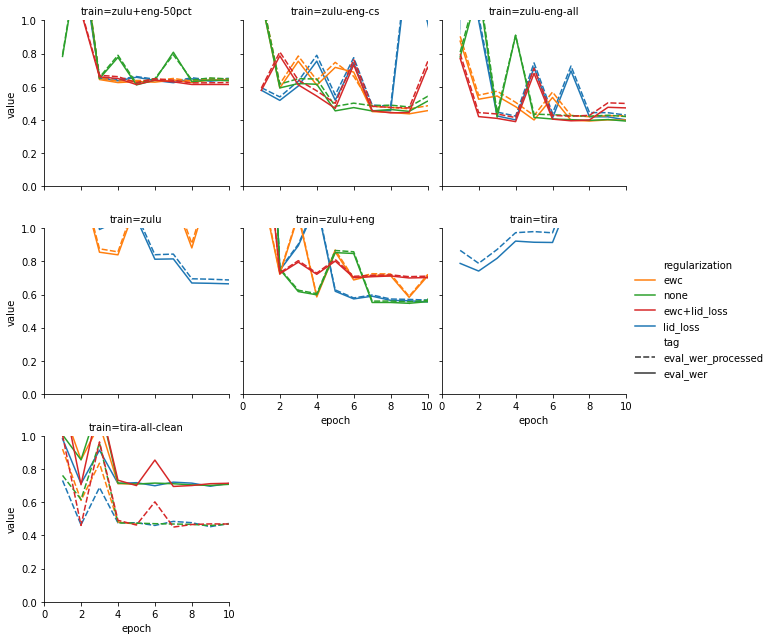

In [177]:
df['beam']=df['beam'].fillna(0).astype(float)
df['lm_alpha']=df['lm_alpha'].astype(str)
g = sb.FacetGrid(
    df[
        # (df['experiment_name'].str.contains('zulu')) &
        # ~(df['experiment_name'].str.contains('zulu-swahili-eng')) &
        # (df['experiment_name'].str.contains('tira')) &
        # (~df['train_data'].str.contains('20-80'))&
        # (~df['train_data'].str.contains('misc'))&
        # (df['train_data'].str.contains('zulu-eng'))&
        # (df['train_data']!='tira-all')&
        # (df['lang_prompt']=='swahili') &
        # (df['lang_prompt']=='croatian')&
        # (df['dataset'].isin(['fl_en', 'tira-clean-split', 'sasoc-cs', 'nchlt_zul'])) &
        (df['dataset'].isin(['sasoc-cs', 'tira-cs'])) &
        (df['ewc_lambda'].isin([0,1])) &
        (df['lid_loss_alpha'].isin([0,0.2])) &
        # (df['beam']==2)&
        (df['beam']==0)&
        (~df['csv_name'].isna())&
        # (df['pred_name'].isna())&
        # (df['regularization']=='none')&
        # (df['tag'].str.contains('loss'))
        # (df['tag']=='train/loss')
        (df['tag'].isin(['eval_wer', 'eval_wer_processed']))
        # (df['metric']!='')
        # (df['LoRA'])
    ],
    # col='ewc_lambda',
    col='train_data',
    col_wrap=3,
    # row='lm_alpha',
    # col='lid_loss_alpha',
    # row='beam',
    # row='dataset',
    # sharey=False,
)
palette_map= {
    key: color for key, color in
    zip(['lid_loss', 'none', 'ewc', 'ewc+lid_loss'], sb.color_palette('husl',4))
}
g.map_dataframe(
    sb.lineplot,
    x='epoch',
    # x='step',
    y='value',
    # y='loss_diff',
    # hue='lid_loss_alpha',
    hue='regularization',
    # palette=palette_map,
    # hue='ewc_lambda',
    # errorbar=None,
    legend='full',
    style='tag',
    # style='tag',
)
# g.set_titles('eval={row_name}, train={col_name}')
g.set_titles('train={col_name}')
g.add_legend()
# g.set_title('Performance on English while decoding as Yoruba')
g.set(ylim=(0,1))
g.set(xlim=(0,10))
plt.show()

In [178]:
df.loc[
        (~df['preds_name'].isna()),
        'experiment_name'
].unique()

array(['whisper-small-tira-eng-cs-clean-ewc-lambda-1',
       'whisper-small-tira-eng-cs-clean', 'whisper-small-tira',
       'whisper-small-tira-lid-alpha-0.2',
       'whisper-small-tira-ewc-lambda-1',
       'whisper-small-tira-lid-alpha-0.2-ewc-lambda-1',
       'whisper-small-tira-eng-ewc-lambda-1',
       'whisper-small-tira-all-clean-lid-alpha-0.2-ewc-lambda-1',
       'whisper-small-tira-eng', 'whisper-small-tira-all-clean',
       'whisper-small-tira-all-clean-lid-alpha-0.2'], dtype=object)

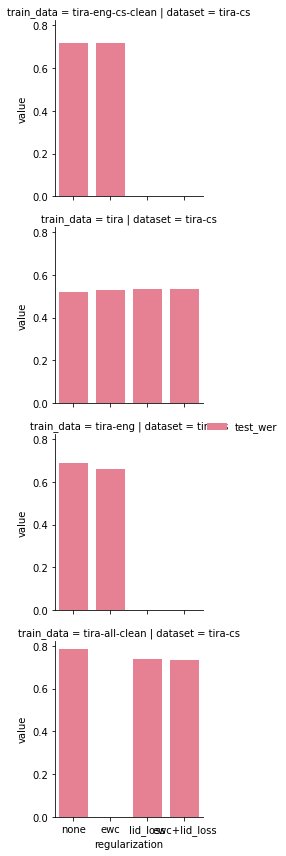

In [179]:
g = sb.FacetGrid(
    df[
        (~df['preds_name'].isna())&
        # (df['tag'].isin(['test_wer', 'test_wer_processed']))
        (df['tag'].isin(['test_wer']))
    ],
    row='train_data',
    col='dataset',
)
g.map_dataframe(sb.barplot, 'regularization', 'value', order=['none', 'ewc', 'lid_loss', 'ewc+lid_loss'], hue='tag', palette='husl')
g.add_legend()
g

In [180]:
df.loc[df['experiment_name']=='whisper-small-tira-ewc-lambda-1','metric'].unique()

array(['', 'wer', 'cer'], dtype=object)

In [193]:
zero_as_baseline = df.copy()
zero_as_baseline.loc[(df['epoch']==0)&(df['train_data'].str.contains('tira')),'train_data']='tira baseline'
zero_as_baseline.loc[(df['epoch']==0)&(df['train_data'].str.contains('zulu')),'train_data']='zulu baseline'
metric_cols = zero_as_baseline[
    # (df['metric']!='')&
    (df['epoch']<=10)&
    # (df['epoch']>1)&
    (((~df['preds_name'].isna())|(~df['csv_name'].isna()))|(df['epoch']==0)) &
    (~(df['tag']).str.contains('test')) &
    # (~(df['tag']).str.contains('processed')) &
    (df['dataset'].isin(['sasoc-cs', 'tira-cs'])) &
    (~df['train_data'].str.contains('misc'))
].pivot_table(
    columns=['regularization'],
    values=['value'],
    index=['train_data', 'epoch', 'metric'],
    aggfunc=lambda x:x.min(),
).pivot_table(
    index=['train_data', 'epoch'],
    columns=['metric'],
).droplevel(
    axis=1,
    level=0
)
reg_names = ['none', 'ewc', 'lid_loss', 'ewc+lid_loss']
reg_dfs = []
for reg in reg_names:
    reg_df=metric_cols[reg]
    reg_df=reg_df.sort_values('wer')
    reg_df=reg_df.reset_index()
    reg_df=reg_df.rename_axis('', axis=1)
    # reg_df=reg_df[reg_df['epoch']>0]
    reg_df=reg_df.drop_duplicates(subset=['train_data'], keep='first')
    reg_df['regularization']=reg
    reg_dfs.append(reg_df)
reg_dfs = pd.concat(reg_dfs)
table=reg_dfs.melt(
    value_vars=['cer', 'wer', 'epoch'],
    var_name='var',
    id_vars=['train_data', 'regularization']
).sort_values(
    'train_data'
).pivot_table(
    columns=['regularization', 'var'],
    index='train_data'
)
table.columns.names=[None,'regularization',None]
table=table.droplevel(0,axis=1)
table=table.reset_index()
is_tira=table['train_data'].str.contains('tira')
table = pd.concat({'Tira': table[is_tira], 'Zulu': table[~is_tira]})
table=table.rename({
    'ewc': 'EWC',
    'lid_loss': 'LID loss',
    'none': 'Plain finetune',
    'ewc+lid_loss': 'EWC+LID loss',
    'train_data': 'Train dataset',
}, axis=1)
table['Train dataset']=table['Train dataset'].map({
    'tira': 'Mono',
    'tira-all-clean': 'All (short)',
    'tira-all-long': 'All (long)',
    'tira-eng': 'Biling',
    'tira-eng-cs-clean': "CS",
    'tira baseline': 'Baseline',
    'zulu': "Mono",
    'zulu+eng': "Biling",
    'zulu+eng-50pct': "Biling (50\\%)",
    'zulu-eng-all': 'All',
    'zulu-eng-cs': 'CS',
    'zulu baseline': 'Baseline',
})

for column in table.columns:
    if column[1]=='epoch':
        table[column]=table[column].astype(int)
    elif column[1]=='':
        pass
    elif column[1] in ('wer', 'cer'):
        table[column]=table[column].apply(lambda n:f"{n:.2f}")
for language in ['Tira', 'Zulu']:
    is_language = table.index.get_level_values(0)==language
    for column in table.columns:
        if column[1] in ('wer', 'cer'):
            min_idx = table.loc[language,column].astype(float).idxmin()
            min_val = table.at[(language,min_idx),column]
            table.loc[(is_language)&(table[column]==min_val),column]=r'\textbf{'+min_val+r'}'
split_bf = lambda s:s.removeprefix(r'\textbf{').removesuffix(r'}')
def italicize_min_per_row(row):
    if row['Train dataset'].item() == 'Baseline':
        return row
    cer = row.index.get_level_values(1)=='cer'
    min_cer_idx = row[cer].apply(split_bf).astype(float).idxmin()
    min_cer_value=row[min_cer_idx]
    row[cer&(row==min_cer_value)]=r'\textit{'+min_cer_value+r'}'

    wer = row.index.get_level_values(1)=='wer'
    min_wer_idx = row[wer].apply(split_bf).astype(float).idxmin()
    min_wer_value=row[min_wer_idx]
    row[wer&(row==min_wer_value)]=r'\textit{'+min_wer_value+r'}'
    return row
table=table.apply(italicize_min_per_row, axis=1)
table=table.loc[:,table.columns.get_level_values(1)!='epoch']
table=pd.concat({
    'Tira':table.loc['Tira'].set_index('Train dataset'),
    'Zulu':table.loc['Zulu'].set_index('Train dataset'),
})
table.columns.names=None,None
ordered_cols = []
for reg in ['Plain finetune', 'EWC', 'LID loss', 'EWC+LID loss']:
    for metric in ['wer', 'cer']:
        ordered_cols.append((reg,metric))
table=table[ordered_cols]
ordered_rows = []
# for ds in ['Baseline', 'Mono', 'Biling', 'CS', 'All (short)', 'All (long)']:
for ds in ['Baseline', 'Mono', 'All (short)']:
    ordered_rows.append(('Tira', ds))
for ds in ['Baseline', 'Mono', 'Biling', 'Biling (50\%)', 'CS', 'All']:
    ordered_rows.append(('Zulu', ds))
table=table.loc[ordered_rows]
table

Plain finetune                 \
                                       wer            cer   
     Train dataset                                          
Tira Baseline                         0.64           0.51   
     Mono           \textit{\textbf{0.62}}  \textit{0.68}   
     All (short)             \textit{0.65}  \textbf{0.35}   
Zulu Baseline                         1.49           0.92   
     Mono                    \textit{0.47}           0.49   
     Biling                           0.37           0.34   
     Biling (50\%)           \textit{0.37}  \textit{0.33}   
     CS                      \textbf{0.28}  \textbf{0.17}   
     All                              0.29  \textbf{0.17}   

                                       EWC                          \
                                       wer                     cer   
     Train dataset                                                   
Tira Baseline                \textbf{0.64}                    0.51   
     Mono                              nan                     nan   
     All (short)                      0.66           \textbf{0.36}   
Zulu Baseline                         1.49                    0.92   
     Mono                    \textit{0.47}           \textit{0.30}   
     Biling                  \textit{0.35}                    0.32   
     Biling (50\%)                    0.38                    0.35   
     CS                      \textit{0.28}  \textit{\textbf{0.15}}   
     All            \textit{\textbf{0.27}}  \textit{\textbf{0.15}}   

                         LID loss                           EWC+LID loss  \
                              wer                     cer            wer   
     Train dataset                                                         
Tira Baseline       \textbf{0.64}                    0.51  \textbf{0.64}   
     Mono                     nan                     nan            nan   
     All (short)    \textit{0.65}           \textbf{0.36}  \textit{0.65}   
Zulu Baseline                1.49                    0.92           1.49   
     Mono                     nan                     nan            nan   
     Biling                  0.36           \textit{0.27}           0.36   
     Biling (50\%)           0.38                    0.35           0.38   
     CS             \textbf{0.28}  \textit{\textbf{0.15}}  \textbf{0.28}   
     All                     0.29                    0.16           0.30   

                                            
                                       cer  
     Train dataset                          
Tira Baseline                         0.51  
     Mono                              nan  
     All (short)    \textit{\textbf{0.34}}  
Zulu Baseline                         0.92  
     Mono                              nan  
     Biling                           0.31  
     Biling (50\%)                    0.34  
     CS             \textit{\textbf{0.15}}  
     All                              0.16

In [ ]:
with open('table.tex', 'w') as f:
    latex_str=table.to_latex(index=True, escape=False, sparsify=True, multirow=False)
    latex_str=latex_str.replace(r'\multicolumn{2}{r}', r'\multicolumn{2}{l}')
    latex_str=latex_str.replace('Zulu','\midrule\nisiZulu')
    f.write(latex_str)

# Lang specific metrics

In [ ]:
df['tag'].unique()

array(['eval/tira_eval-en+sw_cer', 'eval/tira_eval-en+sw_runtime',
       'eval/tira_eval-en+sw_loss', 'eval/sasoc-cs-en+sw_runtime',
       'eval/sasoc-cs-en+sw_loss', 'eval/runtime',
       'eval/sasoc-cs-en+sw_steps_per_second', 'train/epoch',
       'eval/tira_eval-en+sw_wer',
       'eval/tira_eval-en+sw_steps_per_second',
       'eval/tira_eval-en+sw_samples_per_second',
       'eval/sasoc-cs-en+sw_samples_per_second',
       'eval/sasoc-cs-en+sw_cer', 'eval/nchlt_zul_val-sw_wer',
       'eval/steps_per_second', 'eval/samples_per_second',
       'eval/sasoc-cs-en+sw_wer', 'eval/loss', 'eval/fl_en-en_cer',
       'eval/fl_en-en_loss', 'eval/fl_en-en_runtime',
       'eval/fl_en-en_samples_per_second', 'eval/cer',
       'eval/fl_en-en_wer', 'eval/fl_en-en_steps_per_second',
       'eval/nchlt_zul_val-sw_steps_per_second',
       'eval/nchlt_zul_val-sw_cer', 'eval/nchlt_zul_val-sw_runtime',
       'eval/nchlt_zul_val-sw_samples_per_second', 'eval/wer',
       'eval/nchlt_zul_val-sw